<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span></li></ul></div>

#  Прогнозирование заказов такси

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. 

**Задача:** Необходимо спрогнозировать количество заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки и построить модель для такого предсказания.

**Условие Заказчика:** Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Ход выполнения проекта

1. Загрузим данные и выполним их ресемплирование по одному часу.
2. Проанализируем данные.
3. Обучим разные модели с различными гиперпараметрами. Сделаем тестовую выборку размером 10% от исходных данных.
4. Проверим данные на тестовой выборке и сделаем выводы.

### Описание данных

Данные лежат в файле `taxi.csv`.   

Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Загрузка и подготовка данных

In [1]:
# Импорт библиотек
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import (train_test_split, 
                                     TimeSeriesSplit, 
                                     GridSearchCV)
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import time
import warnings

In [2]:
# Задаем количесвто столбцов, которые будут выводиться при обращении к датафреймам
pd.set_option('display.max_columns', None)  

# Вывести из под комментария перед финальным запуском:
# Игнорируем предупреждения о возможных изменениях работы функций в будущих версиях в Pandas
warnings.filterwarnings("ignore") 

In [3]:
# считывание csv-файла
try: 
    main_df = pd.read_csv('/datasets/taxi.csv',
                         index_col=[0],
                         parse_dates=[0])
except:
    main_df = pd.read_csv('taxi.csv',
                         index_col=[0],
                         parse_dates=[0])

Зададим значение `random_state`, которое будет использоваться на протяжении всего проекта. 

In [4]:
RANDOM_STATE = 12345

Создадим копию датафрейма, чтобы убедиться, что данные не испорчены после предобработки.

In [5]:
df = main_df.copy(deep=True)

Ознакомимся с данными:

In [6]:
# Выведем общую информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
# Выведем первые 5 строк датафрейма
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [8]:
# Выведем описание целевого признака
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [9]:
# Проверим расположены ли данные в хронологическом порядке
df.index.is_monotonic

True

**Предварительные выводы:**
* Предоставленные данные представлены более 26тыс. значений
* Пропуски в данных отсутствуют
* Данные расположены в хронологическом порядке
* Периодичность представленных данных равна 10 минут

Ресемплируем данные с периодичностью 1 час и просуммируем количество заказа в одном часе.

In [10]:
df = df.resample("1H").sum()

Добавим в данные столбцы с плавающим средним значением заказов и стандартным отклонение заказов для анализа. Размер скользящего окна зададим равным 20.

In [11]:
df['rolling_mean'] = df['num_orders'].rolling(20).mean()
df['rolling_std'] = df['num_orders'].rolling(20).std()

**Вывод:**
* Подготовили данные к анализу:
    * Произвели ресемплирование данных с 10 минут на 1 час с суммированием заказов;
    * Добавили столбцы с плавающим средним значением заказов и плавающим стандартным отклонением заказов.

## Анализ данных

Выведем временной интервал предоставленных данных:

In [12]:
df.index.min(), df.index.max()

(Timestamp('2018-03-01 00:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

Данные представлены с начала марта по конец августа 2018 года (полгода).

Построим график необработанного временного ряда и посмотрим на его стационарность:

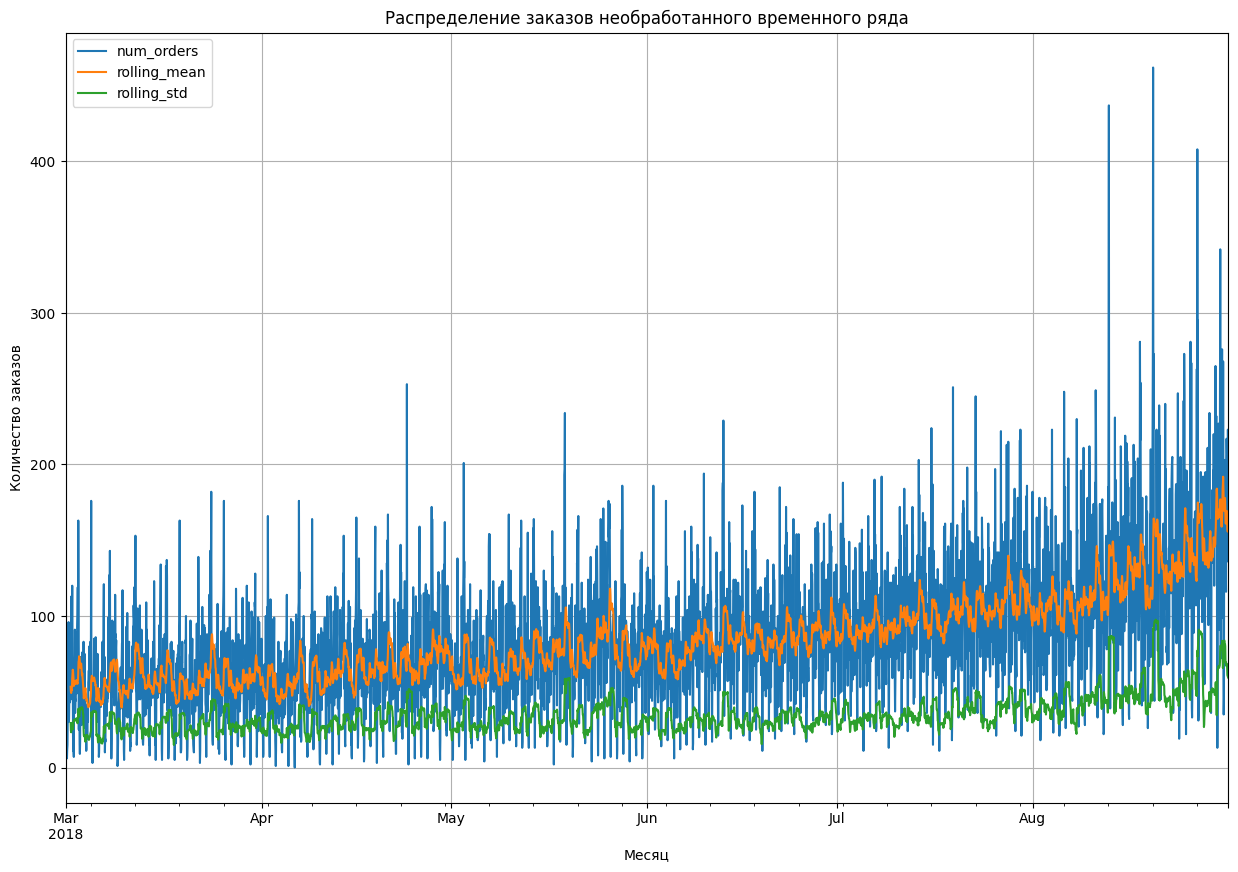

In [13]:
df.plot(figsize=(15, 10),
        title='Распределение заказов необработанного временного ряда',
        xlabel='Месяц',
        ylabel='Количество заказов',
        grid=True);

Применим тест Дикки-Фуллера, чтобы определить стационарность:

In [14]:
ts = df['num_orders']
test = adfuller(ts)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0] > test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -3.068924289027954
p-value:  0.028940051402613028
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
единичных корней нет, ряд стационарен


Уже изначально предоставленный временной ряд имеет стационарный вид.

Теперь посмотрим на тренды и сезонность заказов, предварительно удалив ранее созданные столбцы:

In [15]:
df = df.drop(columns=['rolling_mean', 'rolling_std'])

decomposed = seasonal_decompose(df)

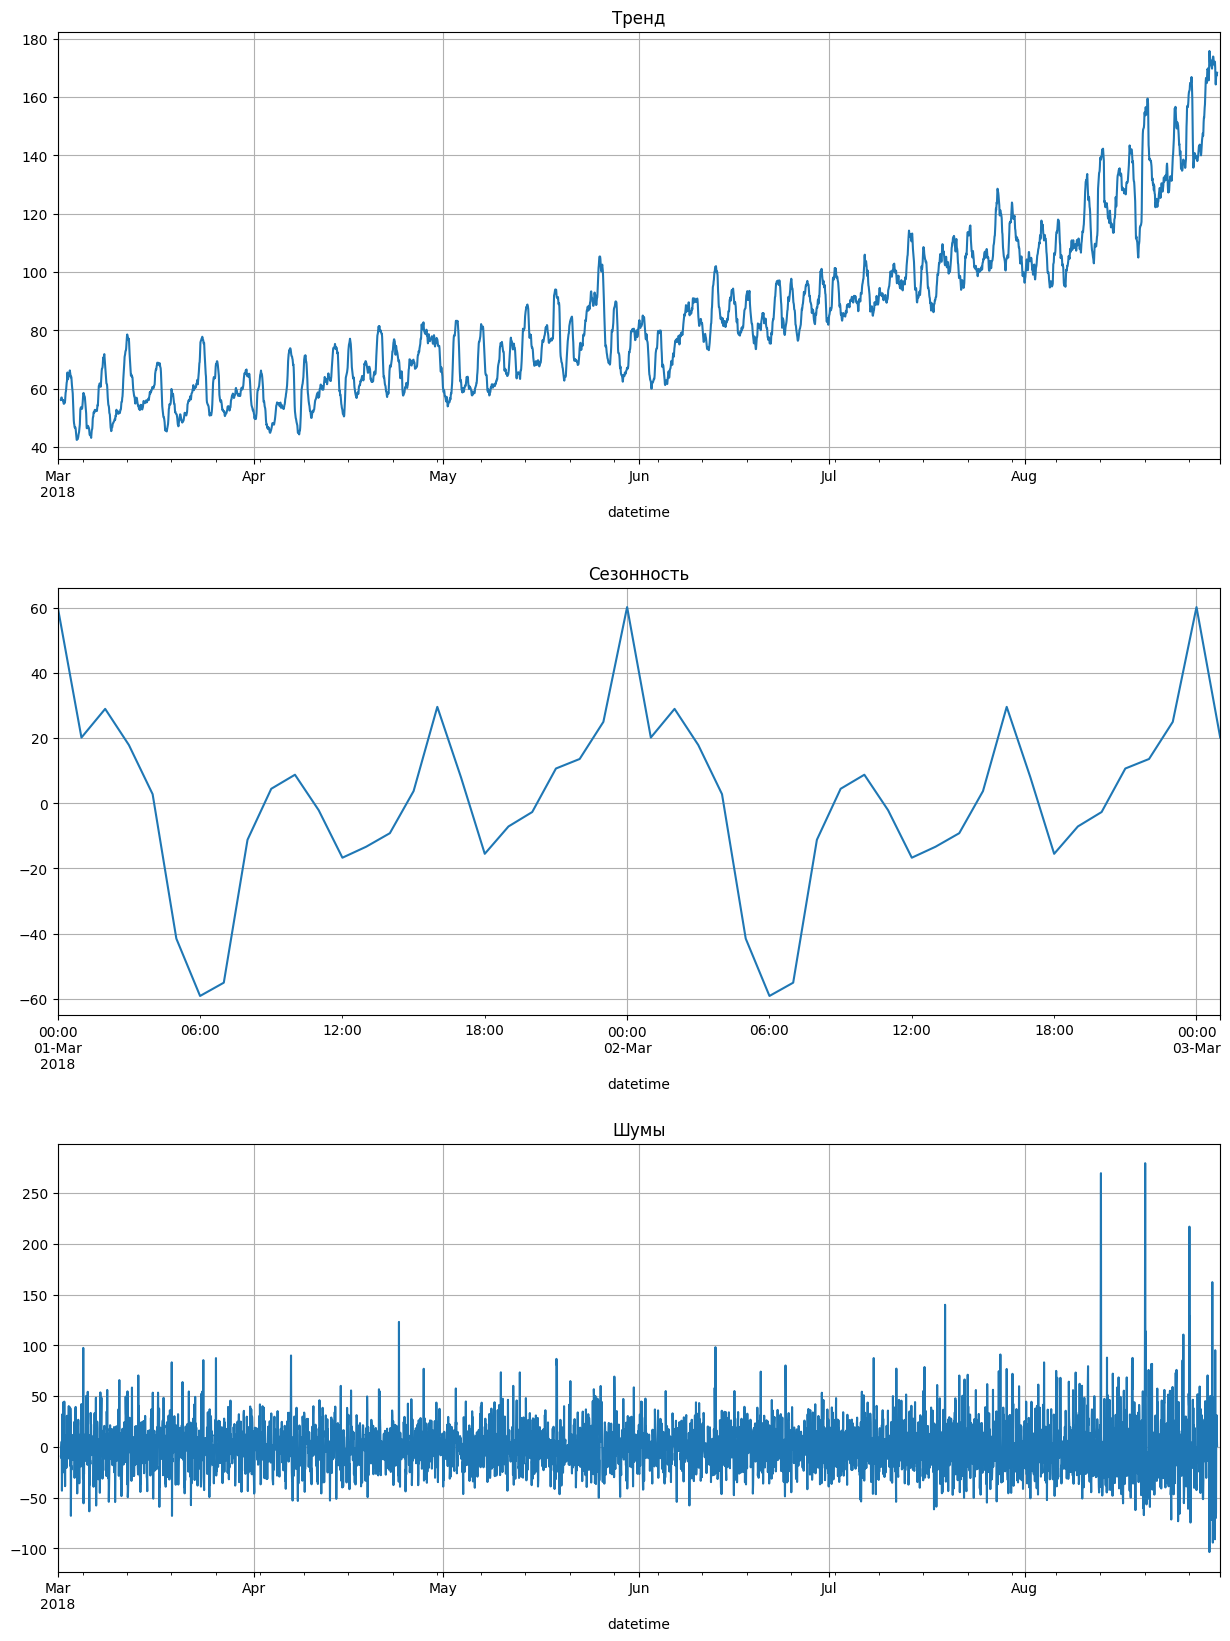

In [16]:
fig, ax = plt.subplots(3, 1, figsize=(15,20))
plt.subplots_adjust(hspace=0.3)

decomposed.trend.plot(ax=ax[0], title='Тренд', grid=True)
decomposed.seasonal.head(50).plot(ax=ax[1], title='Сезонность', grid=True)
decomposed.resid.plot(ax=ax[2], title='Шумы', grid=True);

Посмотрим сезонность в течение недели. Для этого ресемплируем датасет по дню и построим новый график с интервалом около месяца:

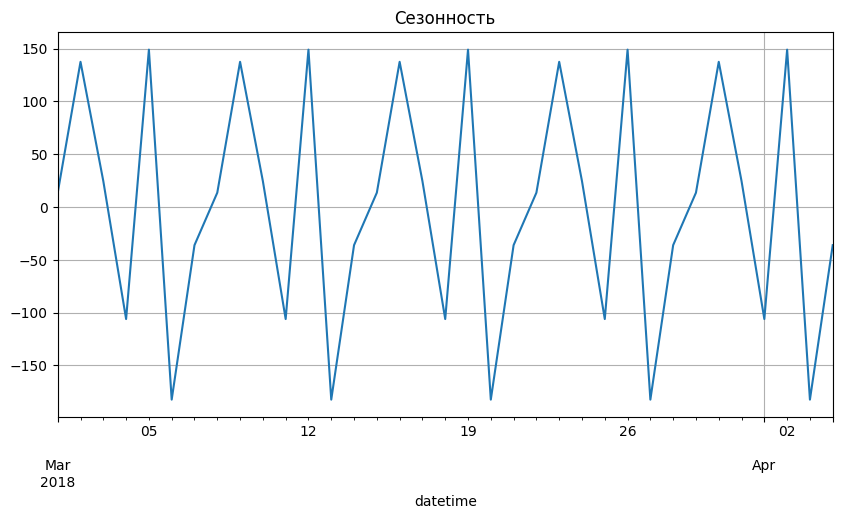

In [17]:
df_new = df.resample("1D").sum()

decomposed_new = seasonal_decompose(df_new)

plt.figure(figsize=(10,5))
decomposed_new.seasonal.head(35).plot(title='Сезонность', grid=True);
plt.show()

**Выводы:**
* Данные имеют восходящий тренд кол-ва заказов от начала весну к концу лета.  
* Сезонность одинаковая каждые сутки: меньше всего заказов около 6 утра, далее кол-во заказов растет до 9 утра (когда все едут на работу), затем следующий росто заказов около 17 часов (когда всег люди возвращаются с работы) и максимальное значение заказов в 12 ночи (когда люди возвращаются домой).
* По недельному графику сезонности видно, что наибольшее количество заказов прихотится на понедельники и пятницы (по данным 5 марта 2018 года - понедельник). Минимум заказов - во вторник и воскресенье.
* По результатам теста Дикки-Фуллера определили, что временной ряд - стационарен.

## Обучение моделей

Создадим функцию, которая добавит признаки, необходимые для обучения модели: 
* Поскольку предоставленные данные охватывают период полугода, то разделим данные на календарные признаки только по дням недели (недельная сезонность) и часу (суточная сезонность);
* Делить признаки на день, месяц и год не будем, т.к. исторические данные представлены периодом менее года и каждый месяц встречается всего один раз. По проведенному анализу заметили, что отсутствует сезонность внутри месяца (в случае добавления - будет просто последовательность чисел).
* Также создадим отстающие значения - предыдущие значения временного ряда покажут, будет ли функция *x(t)* расти или уменьшатся;
* Скользящее среднее - задаст общий тренд временного ряда.

In [18]:
def make_features(data, max_lag, rolling_mean_size):
    '''
    Создает:
    календарные признаки (день недели, час в дне);
    отстающие значения; скользящее среднее
    '''
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()  

In [19]:
# Применим функцию и разделим датафрейм на признаки
make_features(df, 24, 20)
df.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Разделим данные на 2 выборки: обучающую и тестовую в соотношении 9:1, чтобы размер тестовой выборки соответствовал 10% от исходных данных.

In [20]:
train, test = train_test_split(df, 
                               shuffle=False, 
                               random_state=RANDOM_STATE,
                               test_size=0.1)

In [21]:
# Удалим пропущенные значения
train = train.dropna()

In [22]:
print('Размер обучающей выборки:', train.shape)
print('Размер тестовой выборки:', test.shape)

Размер обучающей выборки: (3950, 28)
Размер тестовой выборки: (442, 28)


In [23]:
# Выделим признаки и целевой признак в каждой выборке
def split_data(data, target_column):
    '''
    Выделяет признаки и целевой признак
    '''
    features = data.drop(target_column, axis=1)
    target = data[target_column]
    
    return (features, target)

In [24]:
(features_train, target_train) = split_data(train, 'num_orders')
(features_test, target_test) = split_data(test, 'num_orders')

Данные поделены на вывборки и разделены на признаки. Переходим к обучению моделей.  

In [25]:
# Зададим класс для проведения кросс-валидации
time_split = TimeSeriesSplit(n_splits=5)

In [26]:
# Напишем функцию анализа работы моделей
def model_analyze(model, parameters, features_train, target_train):
    '''
    Принимает на вход объявленную модель обучения,
    сетку параметров, признаки и целевой признак.
    Выводит время обучения, время предсказания и
    наилучшее значение метрики
    '''
    start_fit = time.time()
    # Объявим сетку
    grid = GridSearchCV(model,
                        param_grid=parameters,
                        cv=time_split,
                        n_jobs=-1,
                        scoring='neg_root_mean_squared_error')
    # Обучим модель
    grid.fit(features_train, target_train)
    # Зафиксируем время обучения
    time_fit = time.time() - start_fit
    
    start_predict = time.time()
    predict = grid.predict(features_train)
    # Зафиксируем время предсказания
    time_predict = time.time() - start_predict
    
    # Рассчитаем значение метрики
    rmse = np.sqrt(mean_squared_error(target_train, predict))
    model_results = [time_fit, time_predict, grid.best_score_]
    print(model)
    print('Время обучения:', time_fit)
    print('Время предсказания', time_predict)
    print('Лучший результат RMSE', grid.best_score_)
    
    return model_results, grid

### RandomForest

In [27]:
# Объявим модель
model_rf = RandomForestRegressor()

In [28]:
# Объявим сетку параметров модели
parameters_rf = {'n_estimators': [50, 100, 150],
                 'max_depth': [10, 20, 30],
                 'max_features': [3, 6, 9],
                 'random_state': [RANDOM_STATE]}

In [29]:
results_rf, grid_rf = model_analyze(model_rf,
                                    parameters_rf,
                                    features_train,
                                    target_train)

RandomForestRegressor()
Время обучения: 75.84117794036865
Время предсказания 0.2154247760772705
Лучший результат RMSE -24.776656013421974


In [30]:
grid_rf

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30], 'max_features': [3, 6, 9],
                         'n_estimators': [50, 100, 150],
                         'random_state': [12345]},
             scoring='neg_root_mean_squared_error')

### Ridge

In [31]:
# Объявим модель
model_ridge = Ridge()

In [32]:
# Объявим сетку параметров модели
parameters_ridge = {'alpha': np.arange(0, 0.21, 0.01),
                    'random_state': [RANDOM_STATE]}

In [33]:
results_ridge, grid_ridge = model_analyze(model_ridge,
                                          parameters_ridge,
                                          features_train,
                                          target_train)

Ridge()
Время обучения: 1.2081761360168457
Время предсказания 0.004986763000488281
Лучший результат RMSE -27.135276463284235


In [34]:
grid_ridge

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ]),
                         'random_state': [12345]},
             scoring='neg_root_mean_squared_error')

### LightGBM

In [35]:
# Объявим модель
model_lgbm = LGBMRegressor()

In [36]:
# Объявим сетку параметров модели
parameters_lgbm = {'n_estimators': [90, 180, 310],
                   'max_depth': [7, 14, 20],
                   'num_leaves': [8, 15, 30],
                   'learning_rate': [0.1, 0.5],
                   'random_state': [RANDOM_STATE]}

In [37]:
results_lgbm, grid_lgbm = model_analyze(model_lgbm,
                                        parameters_lgbm,
                                        features_train,
                                        target_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4836
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 27
[LightGBM] [Info] Start training from score 78.421013
LGBMRegressor()
Время обучения: 687.6491060256958
Время предсказания 0.016954660415649414
Лучший результат RMSE -24.50725862809303


In [38]:
grid_lgbm

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.5], 'max_depth': [7, 14, 20],
                         'n_estimators': [90, 180, 310],
                         'num_leaves': [8, 15, 30], 'random_state': [12345]},
             scoring='neg_root_mean_squared_error')

### XGBoost

In [39]:
# Объявим модель
model_xgb = XGBRegressor()

In [40]:
# Объявим сетку параметров модели
parameters_xgb = {'learning_rate':[0.1, 0.5],
                  'max_depth':[6, 12],
                  'subsample':[0.5],
                  'colsample_bytree':[0.5],
                  'random_state':[RANDOM_STATE]}

In [41]:
results_xgb, grid_xgb = model_analyze(model_xgb,
                                      parameters_xgb,
                                      features_train,
                                      target_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Время обучения: 9.88251519203186
Время предсказания 0.008974075317382812
Лучший результат RMSE -24.944718007484415


In [42]:
grid_xgb

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5], 'learning_rate': [0.1, 0.5],
                         'max_depth': [6, 12], 'random_state': [12345],
                         'subsample': [0.5]},
             scoring='neg_root_mean_squared_error')

### CatBoost

In [43]:
# Объявим модель
model_cb = CatBoostRegressor()

In [44]:
# Объявим сетку параметров модели 
parameters_cb = {'learning_rate': [0.1, 0.5],
                 'iterations': [25, 90, 210],
                 'max_depth': [7, 17, 28],
                 'random_state':[RANDOM_STATE]}

In [45]:
results_cb, grid_cb = model_analyze(model_cb,
                                    parameters_cb,
                                    features_train,
                                    target_train)

0:	learn: 36.8895771	total: 140ms	remaining: 29.3s
1:	learn: 35.3021909	total: 146ms	remaining: 15.2s
2:	learn: 33.7297532	total: 152ms	remaining: 10.5s
3:	learn: 32.4528158	total: 158ms	remaining: 8.15s
4:	learn: 31.2582385	total: 164ms	remaining: 6.74s
5:	learn: 30.3063342	total: 170ms	remaining: 5.8s
6:	learn: 29.5043823	total: 176ms	remaining: 5.12s
7:	learn: 28.6427126	total: 183ms	remaining: 4.62s
8:	learn: 27.8932504	total: 189ms	remaining: 4.22s
9:	learn: 27.2694314	total: 196ms	remaining: 3.91s
10:	learn: 26.6904304	total: 202ms	remaining: 3.65s
11:	learn: 26.1731397	total: 208ms	remaining: 3.43s
12:	learn: 25.7499620	total: 214ms	remaining: 3.24s
13:	learn: 25.4194401	total: 220ms	remaining: 3.08s
14:	learn: 25.0889221	total: 226ms	remaining: 2.94s
15:	learn: 24.8293008	total: 232ms	remaining: 2.82s
16:	learn: 24.5270933	total: 238ms	remaining: 2.71s
17:	learn: 24.2422521	total: 244ms	remaining: 2.61s
18:	learn: 24.0014992	total: 250ms	remaining: 2.52s
19:	learn: 23.7999827	t

181:	learn: 15.7343182	total: 1.38s	remaining: 212ms
182:	learn: 15.7061848	total: 1.39s	remaining: 205ms
183:	learn: 15.7043500	total: 1.4s	remaining: 197ms
184:	learn: 15.6673837	total: 1.4s	remaining: 189ms
185:	learn: 15.6283299	total: 1.41s	remaining: 182ms
186:	learn: 15.5660537	total: 1.42s	remaining: 174ms
187:	learn: 15.5346802	total: 1.42s	remaining: 166ms
188:	learn: 15.5014578	total: 1.43s	remaining: 159ms
189:	learn: 15.4678357	total: 1.44s	remaining: 151ms
190:	learn: 15.4287475	total: 1.44s	remaining: 143ms
191:	learn: 15.3873414	total: 1.45s	remaining: 136ms
192:	learn: 15.3514412	total: 1.46s	remaining: 128ms
193:	learn: 15.3280740	total: 1.46s	remaining: 121ms
194:	learn: 15.2955593	total: 1.47s	remaining: 113ms
195:	learn: 15.2654842	total: 1.48s	remaining: 105ms
196:	learn: 15.2240441	total: 1.48s	remaining: 97.8ms
197:	learn: 15.1984972	total: 1.49s	remaining: 90.2ms
198:	learn: 15.1684329	total: 1.49s	remaining: 82.6ms
199:	learn: 15.1289445	total: 1.5s	remaining:

In [46]:
grid_cb

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x00000266D1AC0B50>,
             n_jobs=-1,
             param_grid={'iterations': [25, 90, 210],
                         'learning_rate': [0.1, 0.5], 'max_depth': [7, 17, 28],
                         'random_state': [12345]},
             scoring='neg_root_mean_squared_error')

## Тестирование лучшей модели

Чтобы определить лучшую модель, сведем показатели всех моделей в единую таблицу:

In [47]:
results = pd.DataFrame([results_rf, results_ridge, results_lgbm, results_xgb, results_cb],
                      columns=['Время обучения', 'Время предсказания', 'Лучший результат RMSE'],
                      index=['RandomForest', 'Ridge', 'LightGBM', 'XGBoost', 'CatBoost'])
results.round(2)

,Время обучения,Время предсказания,Лучший результат RMSE
RandomForest,75.84,0.22,-24.78
Ridge,1.21,0.00,-27.14
LightGBM,687.65,0.02,-24.51
XGBoost,9.88,0.01,-24.94
CatBoost,17.17,0.00,-24.51


По сумме показателей наилучшим образом себя показала модель *CatBoost* - у нее наивысшее значение *RMSE*. У линейной модели *Ridge* наивысшая скорость обучения, но наихудшее *RMSE*.  

Для тестирования выберем модель *CatBoost*.

In [48]:
# Получим предсказания лучшей модели на тестовой выборке
predict_test = grid_cb.predict(features_test)

In [49]:
# Посчитаем RMSE
rmse_test = np.sqrt(mean_squared_error(target_test, predict_test))
print('RMSE тестовой выборки:', rmse_test.round(2))

RMSE тестовой выборки: 41.63


**Вывод:**  
В ходе работы над проектом проделана следующая работа:
* Исследованы исходные данные и подготовлены к анализу (проведено ресемплирование данных по 1 часу);
* Проведен анализ данных:
    * Построены графики временных рядов
    * Выявлен возврастающий тренд заказов такси от начала весны к концу лета
    * Определена сезонность заказов такси, равная одному дню, также отдельно выведена сезонность за в течение недели
* Данные поделены на обучающую и тестовую выборки
* Проведено обучение 5 моделей: `RandomForestRegressor`, `Ridge`, `LGBMRegressor`, `XGBRegressor` и `CatBoostRegressor`
* Определена наилучшая модель по сумме показателей (время обучения, время предсказания и лучшее RMSE модели) - *CatBoostRegressor*
* Проведено тестирование лучшей модели, в ходе которого получили значение *RMSE* равное 41.63, что удовлетворяет условию Заказчика (не превышает 48).